In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# import Fashion MNIST

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/256. + 0.5/256
x_test = x_test.astype('float32')/256 + 0.5/256
example_x = x_test[:16]

batch_size=32
x_train = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(batch_size)
x_test = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(batch_size)

Notice that the images are scaled to be between 0 and 1. This is because the decoding distribution is going to envolve beta distributions, which only have non-zero density in the interval between 0 and 1.

In [13]:
# Define latent_size and the prior, p(z)

latent_size=4

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [15]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer

event_shape = (28, 28)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior) # estimates KL [ q(z|x) || p(z)]
])

# samples z_j from q(z|x_j) 
# then computes log q(z_j|x_j) - log p(z_j)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


The final dense layer outputs a vector of unconstraint real values. The `MultivariateNormalTriL` the receives this vector and interprets it as the location and lower triangular matrix with positive diagonal.

In [16]:
# See how `KLDivergenceAddLoss` affects `encoder.losses`
# encoder.losses before the network has received any inputs

encoder.losses

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [17]:
# Pass a batch of images through the encoder

encoder(example_x)

<tfp.distributions.MultivariateNormalTriL 'sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[16] event_shape=[4] dtype=float32>

In [18]:
# See how the encoder.losses has changed

encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.99569255>]

In [20]:
# Respecify the encoder using `weight` and `test_points_fn`

event_shape = (28, 28)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior,
                            use_exact_kl=False,
                            weight=1.5,
                            test_points_fn=lambda q: q.sample(10),
                            test_points_reduce_axis=0) # estimates KL [ q(z|x) || p(z)]
])

# (n_samples, batch_size, dim_z)
# z_{ij} is the ith sample for the observation x_j (is at (i, j, :) in tensor of samples)
# is mapped to log q(z_{ij}|x_j) - log p(z_{ij})
# => tensor of KL divergences has shape (n_samples, batch_size)

In [22]:
# Replace `KLDivergenceAddLoss` with `KLDivergenceRegularizer` in the previous (probabilistic) layer

divergence_regularizer = tfpl.KLDivergenceRegularizer(prior, 
                                                     use_exact_kl=False,
                                                     test_points_fn = lambda q: q.sample(5),
                                                     test_points_reduce_axis=0)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size,
                               activity_regularizer=divergence_regularizer)
])


In [23]:
# Specify the decoder, p(x|z)

decoder = Sequential([
    Dense(16, activation='sigmoid', input_shape=(latent_size,)),
    Dense(32, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(2*event_shape[0]*event_shape[1], activation='exponential'),
    Reshape((event_shape[0], event_shape[1], 2)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Beta(concentration1=t[..., 0],
                     concentration0=t[..., 1])
        )
    )
])

In the decoder we are using an exponential activation function to ensure that the paramters that are later passed to the beta distributions are non-negative. Since there it not an Independent Beta layer, we are using a Distribution Lambda, Independent and Beta to build one.

In [24]:
# Connect the encoder and decoder to form the VAE

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [26]:
# Define a loss that only estimates the expected reconstruction error,
# -E_{Z - q(z|x)}[log p(x|z)]

def log_loss(x_true, p_x_given_z):
    return(-tf.reduce_sum(p_x_given_z.log_prob(x_true)))

We already included the KL term to our loss function, so we only need to include here the reconstruction loss. We do it via one sample MC estiamte.

In [29]:
# Compile and fit the model

vae.compile(loss=log_loss)

vae.fit(x_train, validation_data=x_test, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: -40646.3815 - val_loss: -49858.3711
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: -52033.6174 - val_loss: -55359.4570
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: -55760.9972 - val_loss: -55711.9570
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: -57389.4405 - val_loss: -57899.5664
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: -58458.3007 - val_loss: -61834.7539
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: -62214.1478 - val_loss: -64143.6094
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: -64714.8849 - val_loss: -66730.5703
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: -66257.8222 - val_loss: -67222.6875
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: -67230.8873 - val_loss: 

In [33]:
# Generate an example reconstruction

example_reconstruction = vae(example_x).mean().numpy().squeeze()

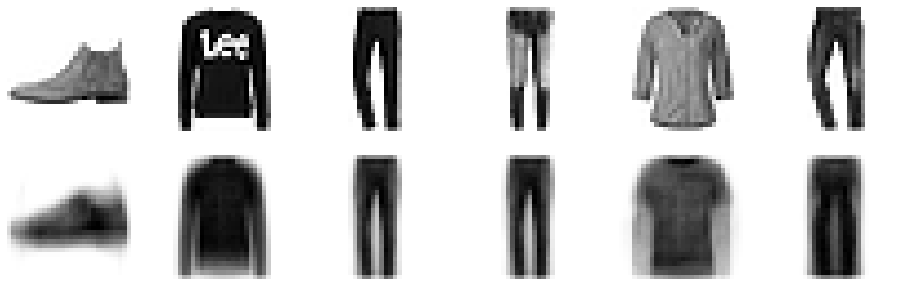

In [34]:
# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')